<h1>Neural Network for MNIST Classification</h1>

![Google Drive Image](https://drive.google.com/uc?export=view&id=1ROss6oc31MUBGY6PzAqaTi2BGmTEir5q)

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
import torch.nn.functional as F
import torch.cuda
import matplotlib.pylab as plt
import numpy as np
import time

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")
print(torch.version.cuda)

Training on: cuda
11.8


## 1. Load MNIST Data

In [35]:
# Define the plot functions to show the data
IMAGE_SIZE = 28
def show_raw_data(data_sample):
    image_array = np.asarray(data_sample[0]).reshape((IMAGE_SIZE, IMAGE_SIZE))
    plt.imshow(image_array, cmap=plt.get_cmap('gray'), interpolation="None")
    plt.title('y = '+ str(data_sample[1]))

def show_tensor_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

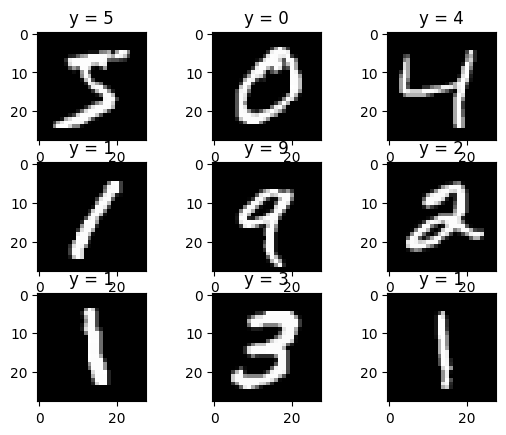

In [36]:
# Load raw data
data_train = dataset.MNIST(root="./data", train=True, download=True)
data_test = dataset.MNIST(root="./data", train=False, download=True)

# Show some samples
for i in range(9):
    plt.subplot(330 + 1 + i)
    show_raw_data(data_train[i])
plt.show()

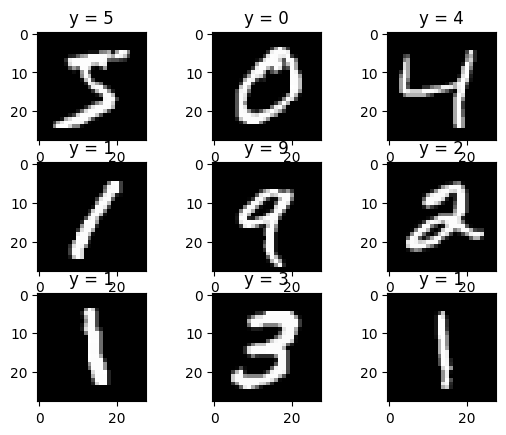

In [37]:
# Declare the transformation operation
IMAGE_SIZE = 28  # or 16
transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

# Load data and apply transform to tensor
train_dataset = dataset.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = dataset.MNIST(root='./data', train=False, download=True, transform=transform)

# Show some samples
for i in range(9):
    plt.subplot(330 + 1 + i)
    show_tensor_data(train_dataset[i])
plt.show()

In [38]:
# Create the training data loader and validation data loader object
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=128, shuffle=False)

## 2. Neural Network Module

### 2.1. Very simple neural network with no hidden layers
<img src="https://drive.google.com/uc?export=view&id=1VKno2UNK6loLnnPX5WVYUJ0A_G9tHlxV" width="600"/>

In [41]:
class SimpleNet(nn.Module):
    def __init__(self, D_in, D_out):
        """
        D_in: the input size of the input layer
        D_out: the output size of the output layer
        """
        super(SimpleNet, self).__init__()
        self.linear = nn.Linear(D_in, D_out)

    def forward(self,x):
        x = torch.sigmoid(self.linear(x))
        return x

### 2.2. Neural network with 2 hidden layers using Sigmoid Activation
<table><tr>
<td> <img src="https://drive.google.com/uc?export=view&id=1tZbdF6bnhk6TUTz9Ju-tQgLiKyeaia0V" height="300"/> </td>
<td> </td>
<td> <img src="https://drive.google.com/uc?export=view&id=1olvz1kw4RAg3HNDPAVWUXQZkbMXQpGwz" height="300"/> </td>
</tr></table>


In [43]:
# Create the model class using Sigmoid as the activation function
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        """
        D_in: the input size of the first layer (size of input layer)
        H1: the input size of second layer (size of first hidden layer)
        H2: the input size of third layer (size of second hidden layer)
        D_out: the output size of the third layer (size of output layer)
        """
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)

    def forward(self,x):
        x = torch.sigmoid(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        x = self.linear3(x)
        return x

### 2.3. Neural network with 2 hidden layers using ReLu Activation
<table><tr>
<td> <img src="https://drive.google.com/uc?export=view&id=1tZbdF6bnhk6TUTz9Ju-tQgLiKyeaia0V" height="300"/> </td>
<td> </td>
<td> <img src="https://drive.google.com/uc?export=view&id=1LO_7-rPeuZpyazIpptXGLrnQRH9wf8aZ" height="300"/> </td>
</tr></table>

<font color='red'>Please put your code in the next cells</font>

In [45]:
# Create the model class using ReLU as the activation function
class NetRelu(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        """
        D_in: the input size of the first layer (size of input layer)
        H1: the input size of the second layer (size of first hidden layer)
        H2: the input size of the third layer (size of second hidden layer)
        D_out: the output size of the final layer (size of output layer)
        """
        super(NetRelu, self).__init__()
        # Define the layers
        self.linear1 = nn.Linear(D_in, H1)  # First hidden layer
        self.linear2 = nn.Linear(H1, H2)    # Second hidden layer
        self.linear3 = nn.Linear(H2, D_out) # Output layer

    def forward(self, x):
        # Apply ReLU activation function after each layer
        x = F.relu(self.linear1(x))   # ReLU after first hidden layer
        x = F.relu(self.linear2(x))   # ReLU after second hidden layer
        x = self.linear3(x)           # Output layer without activation (e.g., used in classification)
        return x

## 3. Define a function to  train the model


In [47]:
def train(model, criterion, train_loader, validation_loader, optimizer, epochs=100, device='cpu', patience=5):
    model.to(device)  # Chuyển mô hình sang GPU nếu có
    useful_stuff = {'training_loss': [], 'validation_accuracy': []}
    
    print(f'Using device: {device}')
    
    start_time = time.time()  # Thời gian bắt đầu huấn luyện
    best_accuracy = 0  # Để lưu độ chính xác tốt nhất
    epochs_without_improvement = 0  # Đếm số epoch không cải thiện

    for epoch in range(epochs):
        model.train()  # Đặt mô hình ở chế độ train
        running_loss = 0.0  # Khởi tạo biến lưu trữ loss trong một epoch
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)  # Chuyển dữ liệu sang GPU
            
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28).to(device))  # Dự đoán
            loss = criterion(z, y)  # Tính loss
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()  # Cộng dồn loss
            
        # Tính và lưu average loss cho epoch
        average_loss = running_loss / len(train_loader)
        useful_stuff['training_loss'].append(average_loss)
        
        # Kiểm tra độ chính xác trên tập kiểm thử
        model.eval()  # Đặt mô hình ở chế độ đánh giá
        correct = 0
        with torch.no_grad():  # Không tính gradient khi kiểm thử
            for x, y in validation_loader:
                x, y = x.to(device), y.to(device)  # Chuyển dữ liệu sang GPU
                z = model(x.view(-1, 28 * 28).to(device))
                _, label = torch.max(z, 1)
                correct += (label == y).sum().item()
        
        accuracy = 100 * (correct / len(validation_loader.dataset))
        useful_stuff['validation_accuracy'].append(accuracy)

        # In thông tin quá trình huấn luyện
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%')
        
        # Kiểm tra xem độ chính xác có cải thiện không
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            epochs_without_improvement = 0  # Reset counter
        else:
            epochs_without_improvement += 1
            
        # Nếu không có cải thiện sau `patience` epoch, dừng huấn luyện
        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch+1} with accuracy: {best_accuracy:.2f}%')
            break
    
    end_time = time.time()  # Thời gian kết thúc huấn luyện
    total_time = end_time - start_time  # Tính thời gian tổng
    print(f'Total training time: {total_time:.2f} seconds')
    
    return useful_stuff

## 4. Training model

### 4.1. Train the simple neural network model

In [50]:

# Hyperparameters
input_dim = 28 * 28  # Dimension of an image
hidden_dim1 = 128
hidden_dim2 = 64
output_dim = 10  # Number of classes
cust_epochs = 80  # Set the number of iterations
learning_rate = 0.01

# Kiểm tra nếu có GPU, sẽ dùng GPU, nếu không thì dùng CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create an instance of the SimpleNet model
model = SimpleNet(input_dim, output_dim)

# Chuyển mô hình lên thiết bị (GPU hoặc CPU)
model.to(device)

# Create the criterion function
criterion = nn.CrossEntropyLoss()

# Create an optimizer that updates model parameters using the learning rate and gradient
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train the model
training_results_simpleNet = train(model, criterion, train_loader, validation_loader, optimizer, epochs=cust_epochs,device=device)


Using device: cuda
Epoch [1/80], Loss: 2.1824, Accuracy: 74.82%
Epoch [2/80], Loss: 2.0179, Accuracy: 80.14%
Epoch [3/80], Loss: 1.9291, Accuracy: 81.73%
Epoch [4/80], Loss: 1.8757, Accuracy: 82.39%
Epoch [5/80], Loss: 1.8400, Accuracy: 83.10%
Epoch [6/80], Loss: 1.8143, Accuracy: 83.74%
Epoch [7/80], Loss: 1.7947, Accuracy: 83.92%
Epoch [8/80], Loss: 1.7791, Accuracy: 84.33%
Epoch [9/80], Loss: 1.7663, Accuracy: 84.73%
Epoch [10/80], Loss: 1.7556, Accuracy: 84.94%
Epoch [11/80], Loss: 1.7465, Accuracy: 85.11%
Epoch [12/80], Loss: 1.7385, Accuracy: 85.37%
Epoch [13/80], Loss: 1.7316, Accuracy: 85.62%
Epoch [14/80], Loss: 1.7254, Accuracy: 85.76%
Epoch [15/80], Loss: 1.7198, Accuracy: 85.92%
Epoch [16/80], Loss: 1.7148, Accuracy: 86.08%
Epoch [17/80], Loss: 1.7102, Accuracy: 86.18%
Epoch [18/80], Loss: 1.7060, Accuracy: 86.25%
Epoch [19/80], Loss: 1.7021, Accuracy: 86.40%
Epoch [20/80], Loss: 1.6986, Accuracy: 86.47%
Epoch [21/80], Loss: 1.6953, Accuracy: 86.55%
Epoch [22/80], Loss: 1.6

### 4.2. Train the neural network model with Sigmoid activation

In [52]:
# Hyperparameters-
input_dim = 28 * 28 # Diemension of an image
hidden_dim1 = 128
hidden_dim2 = 64
output_dim = 10 # Number of classes
cust_epochs = 80 # Set the number of iterations
learning_rate = 0.01
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Create an instance of the Net model
modelSigmoid = Net(input_dim, hidden_dim1, hidden_dim2, output_dim)
modelSigmoid.to(device)
# Create the criterion function
criterion = nn.CrossEntropyLoss()

# Create an optimizer that updates model parameters using the learning rate and gradient
optimizer = torch.optim.SGD(modelSigmoid.parameters(), lr=learning_rate)

# Train the model
training_results_NetSigmoid = train(modelSigmoid, criterion, train_loader, validation_loader, optimizer, epochs=cust_epochs,device=device)

Using device: cuda
Epoch [1/80], Loss: 2.3033, Accuracy: 11.35%
Epoch [2/80], Loss: 2.2981, Accuracy: 11.35%
Epoch [3/80], Loss: 2.2954, Accuracy: 11.35%
Epoch [4/80], Loss: 2.2926, Accuracy: 11.35%
Epoch [5/80], Loss: 2.2889, Accuracy: 11.35%
Epoch [6/80], Loss: 2.2846, Accuracy: 13.18%
Epoch [7/80], Loss: 2.2790, Accuracy: 11.42%
Epoch [8/80], Loss: 2.2715, Accuracy: 16.40%
Epoch [9/80], Loss: 2.2611, Accuracy: 20.78%
Epoch [10/80], Loss: 2.2459, Accuracy: 29.16%
Epoch [11/80], Loss: 2.2230, Accuracy: 32.78%
Epoch [12/80], Loss: 2.1875, Accuracy: 39.42%
Epoch [13/80], Loss: 2.1312, Accuracy: 34.36%
Epoch [14/80], Loss: 2.0447, Accuracy: 37.18%
Epoch [15/80], Loss: 1.9242, Accuracy: 46.25%
Epoch [16/80], Loss: 1.7838, Accuracy: 48.94%
Epoch [17/80], Loss: 1.6492, Accuracy: 51.85%
Epoch [18/80], Loss: 1.5355, Accuracy: 57.86%
Epoch [19/80], Loss: 1.4419, Accuracy: 55.51%
Epoch [20/80], Loss: 1.3614, Accuracy: 61.21%
Epoch [21/80], Loss: 1.2877, Accuracy: 62.39%
Epoch [22/80], Loss: 1.2

### 4.3. Train the neural network model with ReLu activation

<font color='red'>Please put your code in the next cells</font>

In [54]:
# Hyperparameters
input_dim = 28 * 28  # Dimension of an image
hidden_dim1 = 128
hidden_dim2 = 64
output_dim = 10  # Number of classes
cust_epochs = 80  # Number of iterations
learning_rate = 0.01
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Create an instance of the NetRelu model
modelRelu = NetRelu(input_dim, hidden_dim1, hidden_dim2, output_dim)
modelRelu.to(device)
# Create the criterion function
criterion = nn.CrossEntropyLoss()

# Create an optimizer
optimizer = torch.optim.SGD(modelRelu.parameters(), lr=learning_rate)

# Train the model using the same train function as before
training_results_NetRelu = train(modelRelu, criterion, train_loader, validation_loader, optimizer, epochs=cust_epochs,device=device)


Using device: cuda
Epoch [1/80], Loss: 2.1766, Accuracy: 57.06%
Epoch [2/80], Loss: 1.3244, Accuracy: 79.60%
Epoch [3/80], Loss: 0.6913, Accuracy: 85.51%
Epoch [4/80], Loss: 0.5031, Accuracy: 88.39%
Epoch [5/80], Loss: 0.4238, Accuracy: 89.29%
Epoch [6/80], Loss: 0.3815, Accuracy: 90.14%
Epoch [7/80], Loss: 0.3541, Accuracy: 90.48%
Epoch [8/80], Loss: 0.3341, Accuracy: 90.92%
Epoch [9/80], Loss: 0.3186, Accuracy: 91.40%
Epoch [10/80], Loss: 0.3056, Accuracy: 91.62%
Epoch [11/80], Loss: 0.2939, Accuracy: 92.04%
Epoch [12/80], Loss: 0.2837, Accuracy: 92.42%
Epoch [13/80], Loss: 0.2743, Accuracy: 92.71%
Epoch [14/80], Loss: 0.2656, Accuracy: 92.78%
Epoch [15/80], Loss: 0.2574, Accuracy: 93.04%
Epoch [16/80], Loss: 0.2500, Accuracy: 93.22%
Epoch [17/80], Loss: 0.2427, Accuracy: 93.32%
Epoch [18/80], Loss: 0.2356, Accuracy: 93.53%
Epoch [19/80], Loss: 0.2290, Accuracy: 93.63%
Epoch [20/80], Loss: 0.2229, Accuracy: 93.90%
Epoch [21/80], Loss: 0.2169, Accuracy: 93.89%
Epoch [22/80], Loss: 0.2

## 5. Analyze the training results


### 5.1 Compare the training loss for each models
<font color='red'>Please complete code in the next cells</font>

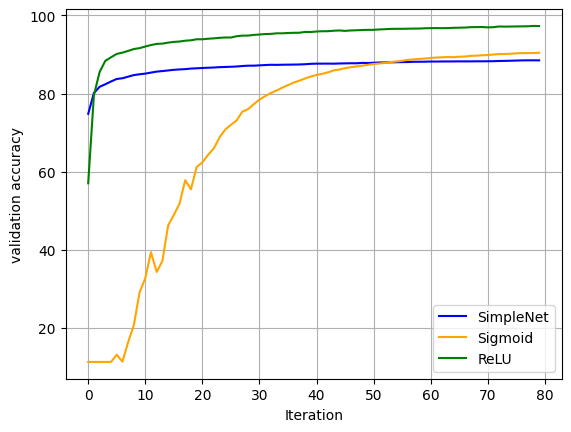

In [78]:
# Plot loss for SimpleNet
plt.plot(training_results_simpleNet['validation_accuracy'], label='SimpleNet', color='blue')

# Plot loss for Net with Sigmoid activation
plt.plot(training_results_NetSigmoid['validation_accuracy'], label='Sigmoid', color='orange')

# Plot loss for Net with ReLU activation
plt.plot(training_results_NetRelu['validation_accuracy'], label='ReLU', color='green')

# Customize the plot
plt.ylabel('validation accuracy')
plt.xlabel('Iteration')
plt.legend()
plt.grid(True)
plt.show()

### 5.2. Compare the validation loss for each model
<font color='red'>Please complete code in the next cells</font>

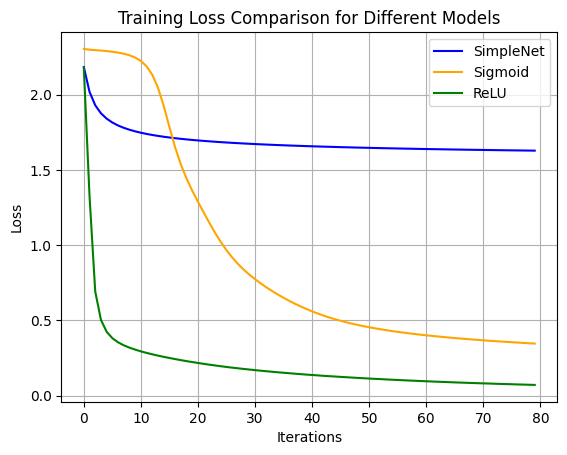

In [59]:
# Plot loss for SimpleNet
plt.plot(training_results_simpleNet['training_loss'], label='SimpleNet', color='blue')

# Plot loss for Net with Sigmoid activation
plt.plot(training_results_NetSigmoid['training_loss'], label='Sigmoid', color='orange')

# Plot loss for Net with ReLU activation
plt.plot(training_results_NetRelu['training_loss'], label='ReLU', color='green')

# Customize the plot
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Comparison for Different Models')
plt.legend()
plt.grid(True)
plt.show()